## Embeddings from scratch

In [80]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
class SkipGramData(Dataset):
    def __init__(self, corpus, window_size = 2):
        super().__init__()
        self.corpus = corpus
        self.window = window_size
        # Create a list for each unique word in the corpus
        self.vocab = list(set([token.lower() for sentence in self.corpus 
                               for token in sentence.split()]))
        
        # Maps to pass from word to index and vice versa
        self.word2idx = {word: idx for idx, word in enumerate(self.vocab)}
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}
        self.data = self.gen_dataset()
    
    def gen_dataset(self):
        data = []
        for sentence in self.corpus:
            text = sentence.lower().split()
            for center_idx, center_word in enumerate(text):
                # For each center word iterate from [-window, window]
                for offset in range(-self.window, self.window + 1):
                    context_idx = center_idx + offset
                    # Escape to next iteraton if the index is out of bounds or the center word
                    if (context_idx < 0 or context_idx >= len(text) or context_idx == center_idx): continue
                    context_word = text[context_idx]
                    # Append a tuple containing the center word and its context
                    data.append((self.word2idx[center_word], self.word2idx[context_word]))
        return data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [3]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        # The embed layer will compress the words on their feature vector
        self.embed_layer = nn.Linear(vocab_size, embedding_size, bias = False)
        # The output layer will be used to compare the result with the context during training
        self.output_layer = nn.Linear(embedding_size, vocab_size)
        
    def forward(self, x):
        return self.output_layer(self.embed_layer(x))

In [12]:
def train_skipgram(model, loss_function, optimizer, data_loader, epochs=100):
    for epoch in range(epochs):
        total_loss = 0
        for center, context in data_loader:
            # Zeros vector (vocabSize)
            center_vector = torch.zeros(len(data_loader.dataset.vocab))
            # Select the desired word with a 1 on its index
            center_vector[center] = 1.0
            # Turn row vector from (vocabSize) to (1, vocavSize)
            center_vector = center_vector.unsqueeze(0)
            # Forward prop
            scores = model(center_vector)
            
            # Calculate losss and backward prop
            loss = loss_function(scores, torch.tensor([context]))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        if epoch % 10 == 0:
            print(f'epoch: {epoch}, loss: {total_loss/len(data_loader)}')


In [16]:
# Corpus
sentences = [
    "La inteligencia artificial está chida",
    "El procesamiento de lenguage natural es una rama del aprendizaje profundo",
    "Me encanta estudiar inteligencia artificial",
    "Las películas de inteligencia artificial me encantan",
    "El aprendizaje profundo es una subcategoría de la inteligencia artificial",
    "Los embeddings de palabras capturan semántica",
    "PyTorch es una herramienta para aprendizaje profundo e inteligencia artificial",
    "Las clases de inteligencia artificial del Doctor Cantoral me encantan",
    "Suscribanse a Pepe Cantoral en YouTube para aprender inteligencia artificial",
    "La casa de Tonio es un buen restaurante para estudiar inteligencia artificial",
    "Odio python pero es la unica herramienta razonable para programar inteligencia artificial"
]

In [ ]:
learning_rate = 0.0001
dataset = SkipGramData(sentences)
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

# The input and output layers need to be as wide as the vocabulary
# then they will be compressed into 300 feature vectors
model = SkipGram(len(dataset.vocab), embedding_size=300)

optimizer = optim.Adam(model.parameters(), lr= learning_rate)
loss_function = nn.CrossEntropyLoss()

In [18]:
train_skipgram(model, loss_function, optimizer,  data_loader, epochs=1000)

epoch: 0, loss: 3.946032669646608
epoch: 10, loss: 3.61314722657935
epoch: 20, loss: 3.212415212136836
epoch: 30, loss: 2.862902421161441
epoch: 40, loss: 2.5821579815419904
epoch: 50, loss: 2.378970284037795
epoch: 60, loss: 2.239894128101735
epoch: 70, loss: 2.1469116761274862
epoch: 80, loss: 2.084943127047065
epoch: 90, loss: 2.0431690146586647
epoch: 100, loss: 2.0143511542147654
epoch: 110, loss: 1.9938666665115239
epoch: 120, loss: 1.9788382722556226
epoch: 130, loss: 1.9674803729803285
epoch: 140, loss: 1.958666978621044
epoch: 150, loss: 1.9516699279378529
epoch: 160, loss: 1.9460046128626982
epoch: 170, loss: 1.941339545637552
epoch: 180, loss: 1.9374417168962443
epoch: 190, loss: 1.9341436704974964
epoch: 200, loss: 1.9313221862711059
epoch: 210, loss: 1.9288849925702334
epoch: 220, loss: 1.9267617787685862
epoch: 230, loss: 1.92489805122826
epoch: 240, loss: 1.923251030818085
epoch: 250, loss: 1.9217866101513612
epoch: 260, loss: 1.9204774279535914
epoch: 270, loss: 1.91930

In [52]:
def plot_embeddings(embeddings, word2idx):
    # TSNE to help visualize the multi dimetional vectors
    tsne = TSNE(n_components=2, random_state=0)
    vectors = tsne.fit_transform(embeddings)
    
    plt.figure(figsize=(20, 10))
    for word, idx in word2idx.items():
        plt.scatter(vectors[idx, 0], vectors[idx, 1])
        plt.annotate(word, xy=(vectors[idx, 0], vectors[idx, 1]), xytext=(5, 2),
                     textcoords='offset points', ha='right', va='bottom')
    plt.title('Word Embeddings Visualized using t-SNE')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.grid(True)
    plt.show()

In [53]:
untrainedModel = SkipGram(len(dataset.vocab), embedding_size=300)

embeddings = untrainedModel.embed_layer.weight.detach().numpy().T

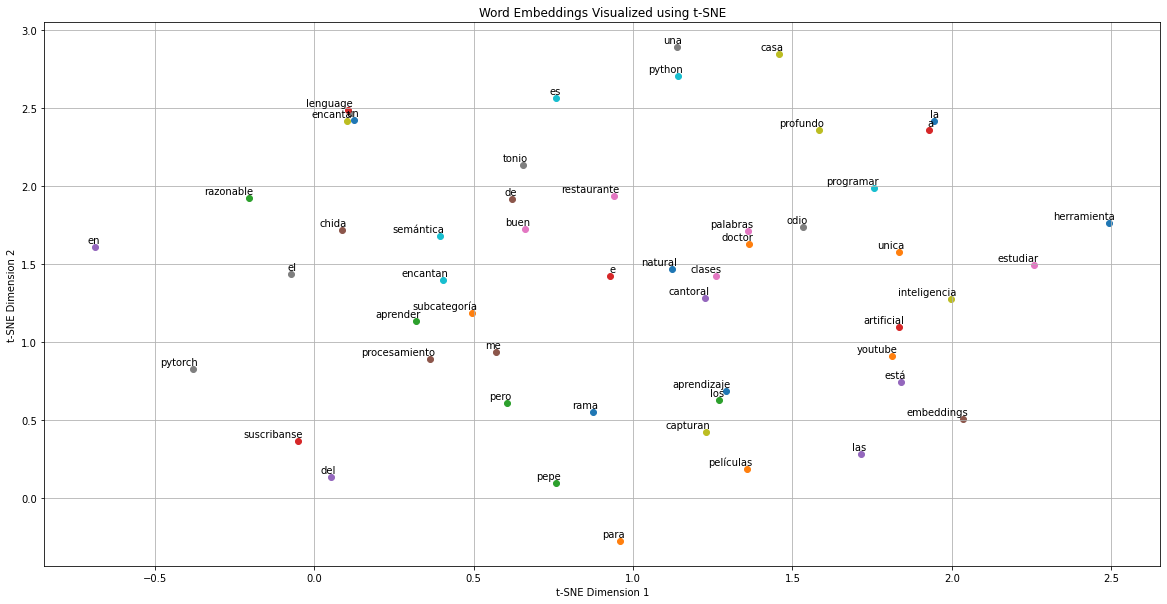

In [55]:
plot_embeddings(embeddings, dataset.word2idx)

In [56]:
embeddings_trained = model.embed_layer.weight.detach().numpy().T

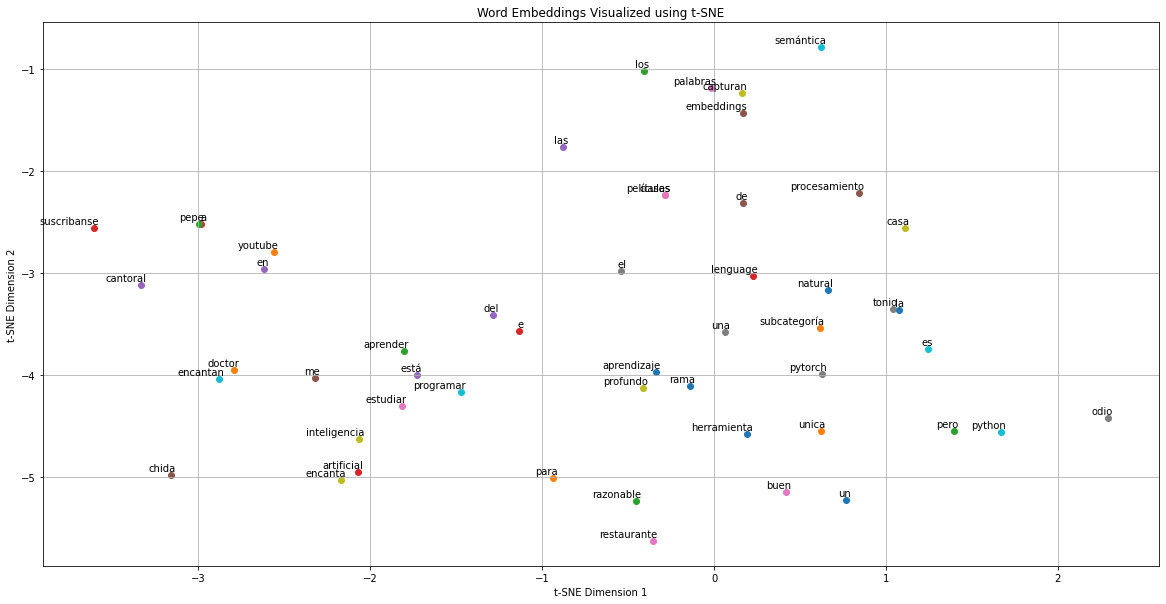

In [58]:
plot_embeddings(embeddings_trained, dataset.word2idx)